In [5]:
import pyodbc
import sqlalchemy as db
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import urllib

In [6]:
def create_params():
    """
    Sets database parameters
    return: params - the database parameters formatted in a string for use with SQLAlchemy
    """
    #Define connection parameters
    driver = "{SQL Server}"
    server = "LAPTOP-UKCTMMGM"
    database_ref = "Premier_League"
    schema = database_ref + ".dbo"
    Trusted_Connection = "Yes" 
    #username = input("Please input SQL Server username") #not needed for my instance
    #password = input("Please input SQL Server password")#not needed for my instance
    params = 'DRIVER='+driver + ';SERVER='+server + ';PORT=1433;DATABASE=' + database_ref + ';Trusted_Connection' + Trusted_Connection 
    return params

In [7]:
#Create engine and query table
def select_view(connection, view, metadata, engine):
    '''
    Takes in two arguments and returns a full view.
    '''
    view = db.Table(view, metadata, autoload=True, autoload_with=engine)
    #Equivalent to 'SELECT * FROM census'
    query = db.select(view) 
    
    ResultProxy = connection.execute(view)
    
    ResultSet = ResultProxy.fetchall()
    
    return ResultSet




In [8]:
def scatter_plot(title, table, x_value, y_value, point_color, x_label, y_label):
    """
    Returns a Scatter Plot
    """
    plt.plot(constrained_layout = True)
    plt.title(title, fontweight='bold')
    plt.scatter(table[x_value], table[y_value], color = point_color)
    plt.xlabel(x_label, fontweight='bold')
    plt.ylabel(y_label, fontweight='bold')
    plt.show()

In [9]:
def line_plot(table, x_values, y_values, x_label, y_label, line_colour):
    """
    Return a line plot
    """
    fig,ax = plt.subplots()
    
    # make a plot
    ax.plot(table[x_values], 
            table[y_values],
            color=line_colour, 
            marker="o")
    for index in range(len(table[x_values])):
      ax.text(table[x_values][index],\
        table[y_values][index] + .2, table[y_values][index], size=12)

    # set x-axis label
    ax.set_xlabel(x_label, fontsize = 14, fontweight='bold')

    # set y-axis label
    ax.set_ylabel(y_label,
                  fontsize=14, fontweight='bold')

    plt.show()

#### Creating a connection to Database

In [10]:
# add db parameters to variable
params = create_params()
db_params = urllib.parse.quote_plus(params)

#Create connection to DWH
my_engine = db.create_engine("mssql+pyodbc:///?odbc_connect={}".format(db_params))
my_connection = my_engine.connect()
metadata =  db.MetaData()

#### Visualising the Data

#### How many yellows and fouls are given in PL games?

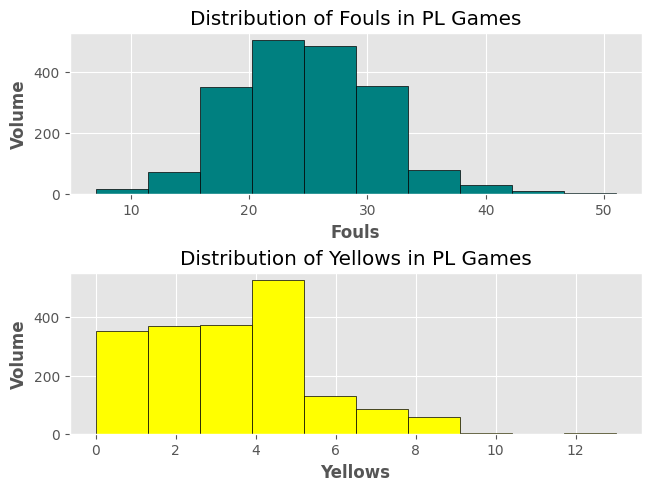

Mean fouls in PL games: 24.75
Mean yellow cards in PL games: 3.33


In [11]:
# 1. How many fouls and yellows are given in PL games?
# 1.1 Get the data from SQL.
fouls_table = pd.read_sql_query("SELECT * FROM Premier_League..fouls_17_22", con=my_connection)
total_fouls = fouls_table['total_fouls']
total_yellows = fouls_table['total_yellows']

# 1.2 plot the distibution
plt.style.use('ggplot')
fig1, ((ax1, ax2)) = plt.subplots(2,1, constrained_layout = True)

ax1.title.set_text('Distribution of Fouls in PL Games')
fouls_dist_bar = ax1.hist(total_fouls, edgecolor = 'black', color = 'teal')
ax1.set_xlabel('Fouls', fontweight='bold')
ax1.set_ylabel('Volume', fontweight='bold')
 

ax2.hist(total_yellows, edgecolor = 'black', color = 'yellow')
ax2.title.set_text('Distribution of Yellows in PL Games')
ax2.set_xlabel('Yellows', fontweight='bold')
ax2.set_ylabel('Volume', fontweight='bold')

plt.show()

# Print the actual means so I can see the averages
print(f"Mean fouls in PL games: {total_fouls.mean().__round__(2)}")
print(f"Mean yellow cards in PL games: {total_yellows.mean().__round__(2)}")

# ANSWER: Games in the Premier League on average have about 25 fouls. 
# There are most often (mode) between 4 and 5 yellow cards but the average amount of yellows is about 3.

#### Has the amount of fouls given away by season changed?

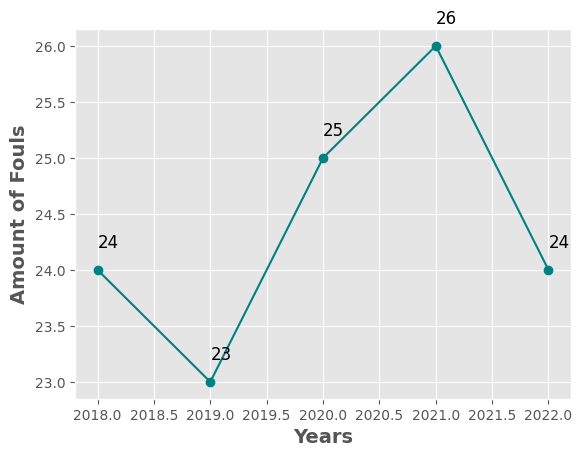

In [12]:
fouls_by_season = pd.read_sql_query("SELECT * FROM Premier_League..vw_PL_fouls_by_season",
                                                 con=my_connection)
fouls_by_season.sort_values(by= "season_end_year", inplace = True) 

line_plot(table = fouls_by_season, x_values = "season_end_year", y_values = "average_fouls", x_label = "Years"\
          ,y_label = "Amount of Fouls", line_colour = "teal")

#### What is the correlation to a teams final statistics vs the total amount of fouls committed in a season?

In [13]:
# 2. TO DO Can also see if there is correlation to total points and fouls in a season?

fouls_to_standings = pd.read_sql_query("SELECT * FROM Premier_League..vw_correlation_fouls_standings",
                                                 con=my_connection)

fouls_standings_correlation = fouls_to_standings.drop(columns = 'season_end_year').corr(numeric_only = True)

fouls_standings_correlation.style.background_gradient(cmap = 'Greys_r')

# Interestingly total fouls are more negatively correlated to a bad performing team. See wins and total fouls has a 
# correlation matrix of -0.548



,total_fouls,total_yellows,points,goal_difference,goals_for,goals_against,wins,losses
total_fouls,1.000000,0.460583,-0.532952,-0.524328,-0.529143,0.430542,-0.547888,0.455896
total_yellows,0.460583,1.000000,-0.386287,-0.395568,-0.326694,0.424665,-0.393016,0.339588
points,-0.532952,-0.386287,1.000000,0.972822,0.934071,-0.864485,0.988836,-0.942965
goal_difference,-0.524328,-0.395568,0.972822,1.000000,0.949944,-0.902713,0.955807,-0.931089
goals_for,-0.529143,-0.326694,0.934071,0.949944,1.000000,-0.723110,0.933846,-0.858003
goals_against,0.430542,0.424665,-0.864485,-0.902713,-0.723110,1.000000,-0.827175,0.876972
wins,-0.547888,-0.393016,0.988836,0.955807,0.933846,-0.827175,1.000000,-0.882835
losses,0.455896,0.339588,-0.942965,-0.931089,-0.858003,0.876972,-0.882835,1.000000


#### Lets see the correlation of total foul count to amount of wins in the PL.

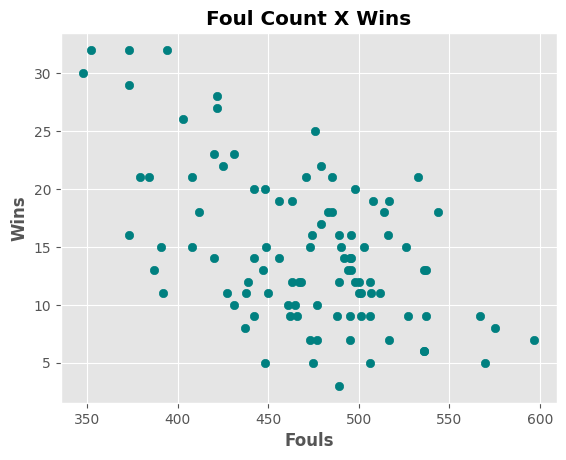

In [14]:
scatter_plot(title = "Foul Count X Wins", table = fouls_to_standings, x_value = "total_fouls", y_value = "wins" \
             , x_label = "Fouls", y_label = "Wins", point_color = "teal" )      

#### Display the referees who give away the most fouls and yellow cards in PL games. 

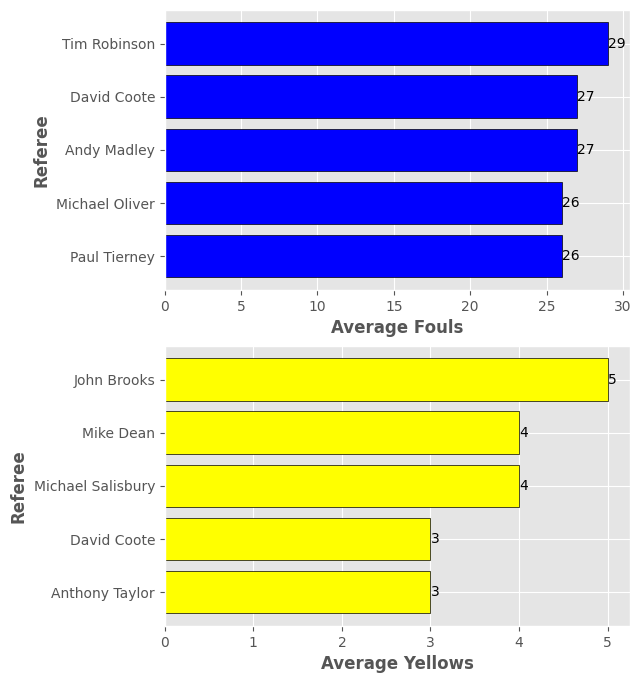

In [15]:
# Which referee gives away the most fouls?
referree_most_fouls = pd.read_sql_query("SELECT * FROM Premier_League..vw_PL_referee_most_fouls",
                                                 con=my_connection)

referees_highest_fouls = referree_most_fouls.sort_values(by = 'average_fouls', ascending= False).head(5).sort_values(by = 'average_fouls', ascending= True)
referees_highest_yellows = referree_most_fouls.sort_values(by = 'average_yellows', ascending= False).head(5).sort_values(by = 'average_yellows', ascending= True)

fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_figwidth(6)
fig.set_figheight(8)

#ax1.set_title('Referee Highest Avg Fouls & Yellows')
fouls_bar = ax1.barh(referees_highest_fouls['referee'], referees_highest_fouls['average_fouls'], edgecolor = 'black', color = 'blue')
ax1.set_ylabel('Referee', fontweight='bold')
ax1.set_xlabel('Average Fouls', fontweight='bold')
ax1.bar_label(fouls_bar)

yellow_bar = ax2.barh(referees_highest_yellows['referee'], referees_highest_yellows['average_yellows'], edgecolor = 'black', color = 'yellow')
ax2.set_ylabel('Referee', fontweight='bold')
ax2.set_xlabel('Average Yellows', fontweight='bold')
ax2.bar_label(yellow_bar)


plt.show()


#### Which team gives away the most/least fouls per game?

In [16]:
team_most_fouls = pd.read_sql_query("SELECT *\
                                     FROM Premier_League..vw_PL_team_fouls_yellow_per_game \
                                     ORDER BY average_fouls DESC"
                                                 , con=my_connection)

team_most_fouls.style.background_gradient(cmap = "Greys")


,team,average_fouls
0,Fulham,14
1,Leeds United,14
2,Sheffield United,14
3,Southampton,13
4,Stoke City,13
5,Manchester United,13
6,Watford,13
7,West Bromwich Albion,13
8,Everton,13
9,Aston Villa,13


#### Which team do specific referees give the highest % of yellow cards for fouls committed?

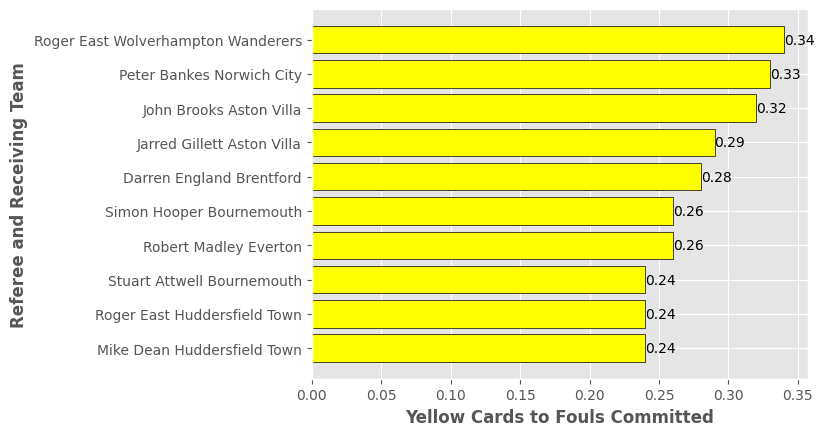

In [17]:
referree_most_hated_team = pd.read_sql_query("SELECT TOP 10 * \
                                              FROM Premier_League..referee_most_hated_team \
                                              ORDER BY yellow_percent DESC",
                                                 con=my_connection)

referree_most_hated_team.sort_values('yellow_percent', inplace = True, ascending = True)

fig, ax = plt.subplots()
hbar = ax.barh(referree_most_hated_team["referee_and_team"], referree_most_hated_team["yellow_percent"],\
    color = "yellow", edgecolor = "black")

ax.set_xlabel("Yellow Cards to Fouls Committed", fontweight='bold')
ax.set_ylabel("Referee and Receiving Team", fontweight='bold')

ax.bar_label(hbar)
plt.show()

#### Does having a referee who gives more yellows cards for fouls committed affect the likelihood of a team winning?

In [18]:
yellow_ratio_match_results = pd.read_sql_query("SELECT * FROM [Premier_League].[dbo].[referee_yellows_to_wins]",
                                                 con=my_connection)

points_by_referee = yellow_ratio_match_results.groupby(by = ["team", "referee"])\
                                              .agg({"yellow_percent" : "mean", "match_points" : "mean"})\
                                              .rename(columns={"match_points":"average_points"})

points_by_referee.corr()

,yellow_percent,average_points
yellow_percent,1.000000,-0.105889
average_points,-0.105889,1.000000


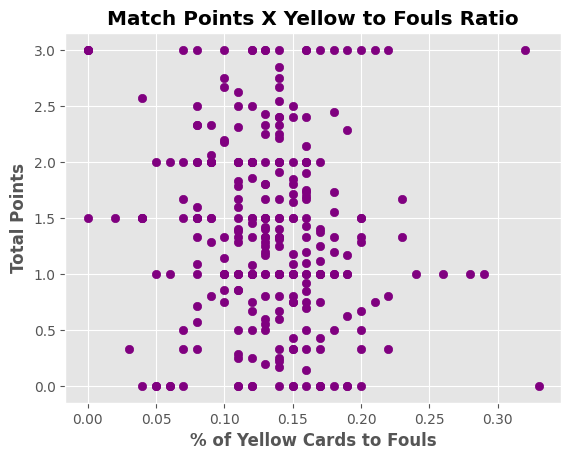

In [19]:
scatter_plot(title = "Match Points X Yellow to Fouls Ratio", table = points_by_referee, x_value = "yellow_percent" \
             ,y_value = "average_points" , x_label = "% of Yellow Cards to Fouls", y_label = "Total Points", point_color = "purple"	)

# There is a slight negative correlation evident from the scatter plot and the correlation figure is refelective of this.


#### How does team performance change playing at home vs away?

In [21]:
points_by_location = yellow_ratio_match_results.groupby(by = ["home_or_away"])\
                                              .agg({"match_points" : "mean"})\
                                              .round(2)\
                                              .rename(columns={"match_points":"total_points"})
points_by_location

# Teams only recieve an average of 0.29 points more per game while playing at home vs away.

,total_points
home_or_away,
Away,1.30
Home,1.59
